# Segmentation & tracking from cell boundaries prediction

This example shows how Ultrack can segment and track from cell boundaries. This is the most natural application of this library because, in other examples, we converted the segmentation labels into contours, and here they are already in a representation analogous to the contour space.

While you can directly track from the membrane channel, we used [PlantSeg](https://github.com/hci-unihd/plant-seg) to enhance the cell boundaries. PlantSeg provides several edges (i.e., boundary) detection pre-trained models, which have shown to generalize well working on Biohub's Zebrafish dataset while trained on Arabidopsis thaliana.

Additionally, `ultrack.imgproc.plantseg` module provides a wrapper around their library to facilitate it's usage on array data.

First we import the required packages.

In [1]:
from typing import Optional

import napari
import numpy as np
import dask.array as da
from napari.utils.notebook_display import nbscreenshot
from rich.pretty import pprint
from numpy.typing import ArrayLike

from ultrack import MainConfig, track, to_tracks_layer, tracks_to_zarr
from ultrack.utils.array import array_apply, create_zarr
from ultrack.imgproc.segmentation import reconstruction_by_dilation
from ultrack.imgproc.plantseg import PlantSeg
from ultrack.utils.cuda import import_module, to_cpu, on_gpu

Next we open a Zebrafish Neuromast dataset from [Adrian's group](https://www.czbiohub.org/jacobo) using napari's ome-zarr reader plugin.

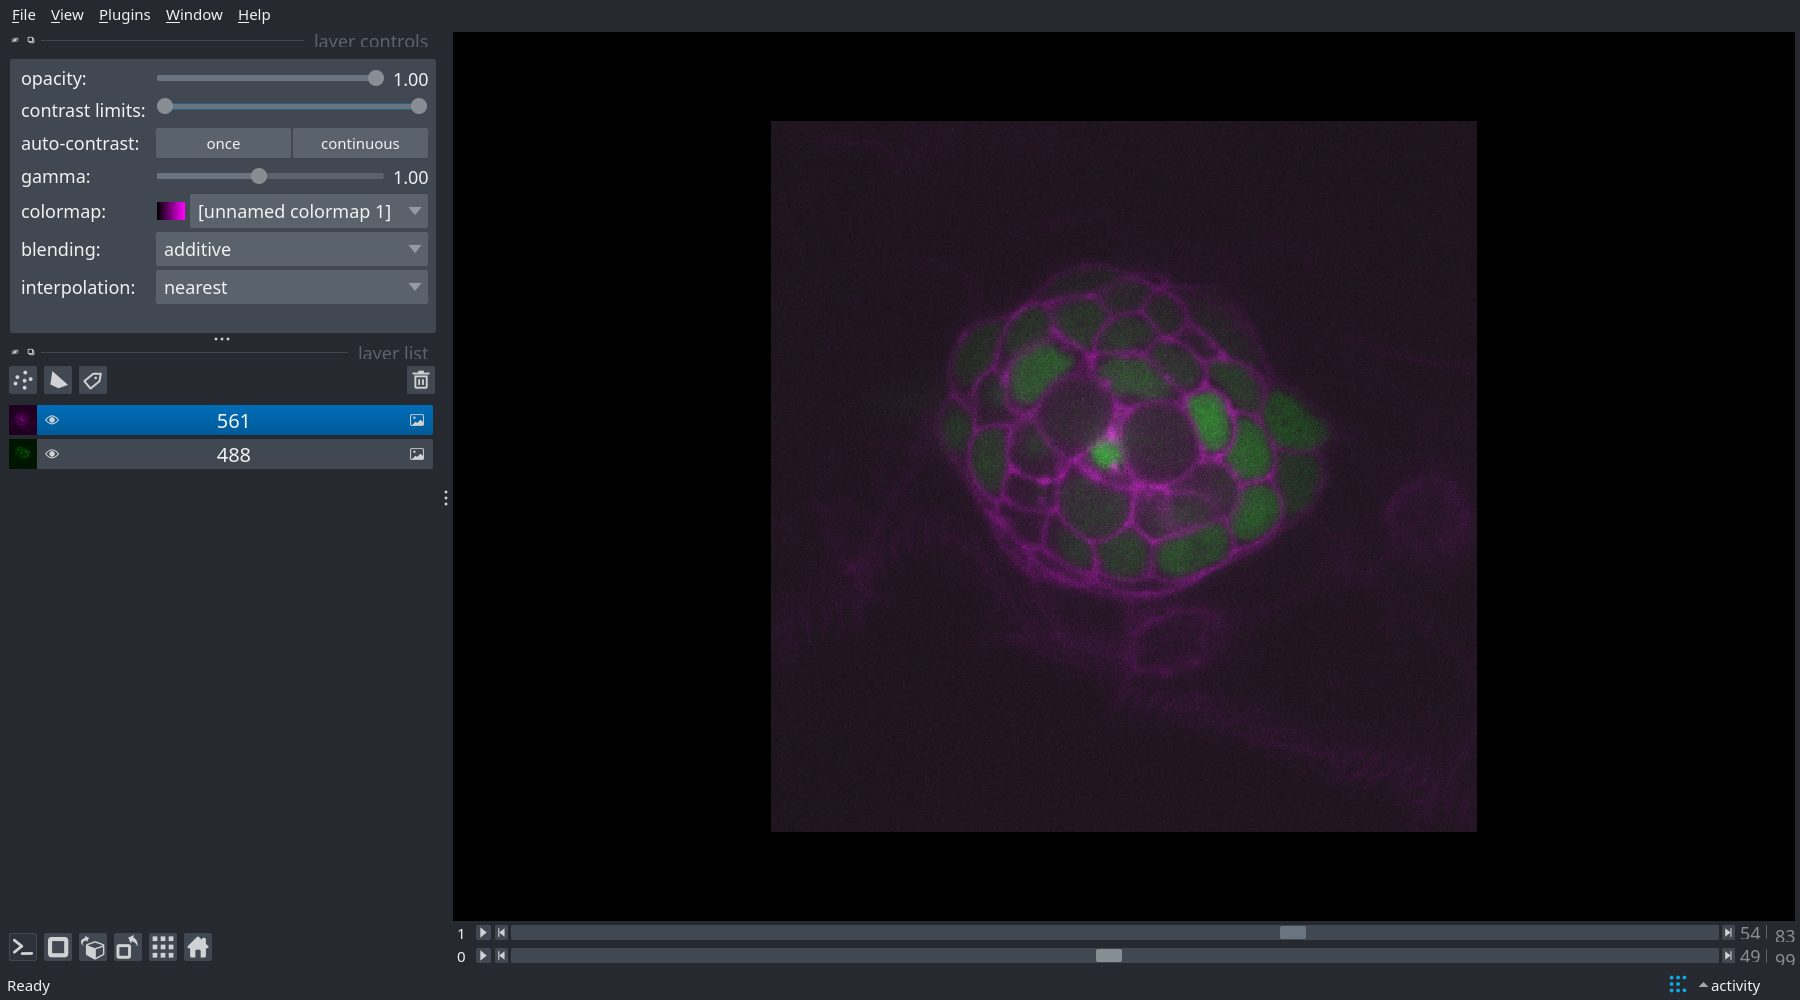

In [2]:
viewer = napari.Viewer()
viewer.window.resize(1800, 1000)

viewer.open(
    "http://public.czbiohub.org/royerlab/ultrack/zebrafish_neuromast.ome.zarr",
    plugin="napari-ome-zarr",
)
viewer.dims.set_current_step(1, 54)

nuclei = viewer.layers["488"].data
membranes = viewer.layers["561"].data
scale = viewer.layers["488"].scale

nbscreenshot(viewer)

Below, we defined a helper function to identify our region of interest, the neuromast, from the background. This step should vary for each application and can be quite challenging in some domains, where more advanced methodologies based on machine learning might be preferred over classical image processing.
Mistakes in detecting the region of interest might lead to non-existing objects, decreasing the tracking accuracy.

In the `detect_neuromast` function, we detect the nuclei and expand into PlantSeg's boundary prediction. However, regions with weak boundaries can let a bit of background be detected.  


In [3]:
# helper functions

def detect_neuromast(
    nuclei: ArrayLike,
    boundaries: ArrayLike,
    sigma: float = 4.0,
    threshold: Optional[float] = None,
    iterations: int = 25,
) -> ArrayLike:
    """
    Fill the boundaries of the binarized nuclei using morphological operations to detection neuromast region.

    Parameters
    ----------
    nuclei : ArrayLike
        Input array representing the nuclei.
    boundaries : ArrayLike
        Input array indicating the cell boundaries.
    sigma : float,
        Gaussian blur sigma applied before detecting nuclei.
    threshold : float, optional
        Threshold value for detecting nuclei. If not provided,
        Otsu's thresholding is applied by default.
    iterations : int
        Iterations used to expand binary nuclei using reconstruction by dilation.

    Returns
    -------
    ArrayLike
        Array with the filled nuclei regions.

    Notes
    -----
    This function fills the boundaries of nuclei while preventing
    the expansion into specified regions, creating a wall-like
    barrier for the expansion.

    Examples
    --------
    >>> nuclei = np.random.rand(256, 256)
    >>> boundaries = np.random.rand(256, 256)
    >>> filled_nuclei = fill_boundaries(nuclei, boundaries)
    """

    filters = import_module("skimage", "filters", nuclei)
    morph = import_module("skimage", "morphology", nuclei)
    segm = import_module("skimage", "segmentation", nuclei)
    ndi = import_module("scipy", "ndimage", nuclei)

    # detecting nuclei with threshold
    seeds = filters.gaussian(nuclei, sigma)
    
    if threshold is None:
        current_thold = filters.threshold_otsu(seeds)
    else:
        current_thold = threshold
    seeds = seeds > current_thold
    
    seeds = morph.binary_closing(seeds, morph.ball(3))

    # closed boundaries mask
    mask = boundaries > 0.25
    mask = ndi.binary_fill_holes(mask, morph.disk(5)[None, ...])

    # expanding nuclei detection to mask
    mask = reconstruction_by_dilation(seeds & mask, mask, iterations)
    mask |= seeds
    
    mask = segm.morphological_geodesic_active_contour(
        boundaries,
        num_iter=10,
        init_level_set=mask,
        smoothing=3,
        balloon=0.1,
    )
    
    # filtering thin objects / holes
    mask = morph.binary_opening(mask, morph.disk(10)[None, ...])
    mask = morph.binary_closing(mask, morph.disk(10)[None, ...])
    mask = ndi.binary_fill_holes(mask, morph.disk(5)[None, ...])

    # boundaries are too thick
    # mask can be eroded to fit image better
    mask = morph.binary_erosion(mask, morph.ball(8))

    return to_cpu(mask)

Next, we allocate the PlantSeg predictor and use it to detect the cell boundaries.
The PlantSeg class has post(pre)-processing functionalities that will be run on the gpu if the array data is on that device.
To do that we wrap the predictor with the `on_gpu` call.

In [4]:
predictor = PlantSeg(
    model_name="generic_light_sheet_3D_unet",
    batch_size=3,
    postprocess_sigma=25.0 * scale[-3:],
    stride_ratio=0.5,
    patch=(64, 256, 256),
    scale_factor=(1, 0.65, 0.65),
)

boundaries = create_zarr(membranes.shape, np.float16, store_or_path="boundaries.zarr", overwrite=True)
array_apply(
    membranes,
    out_array=boundaries,
    func=on_gpu(predictor),
)

layer = viewer.add_image(boundaries, visible=True, scale=scale)
nbscreenshot(viewer)
layer.visible = False

2023-09-28 21:52:43,192 [MainThread] INFO PlantSeg - Using batch size of 4 for prediction


INFO:PlantSeg:Using batch size of 4 for prediction
Applying PlantSeg ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:58<00:00,  1.79s/it]


Using the detected boundaries and the nuclei channel we detect the neuromast, also with the `on_gpu` call.

Applying detect_neuromast ...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.51s/it]


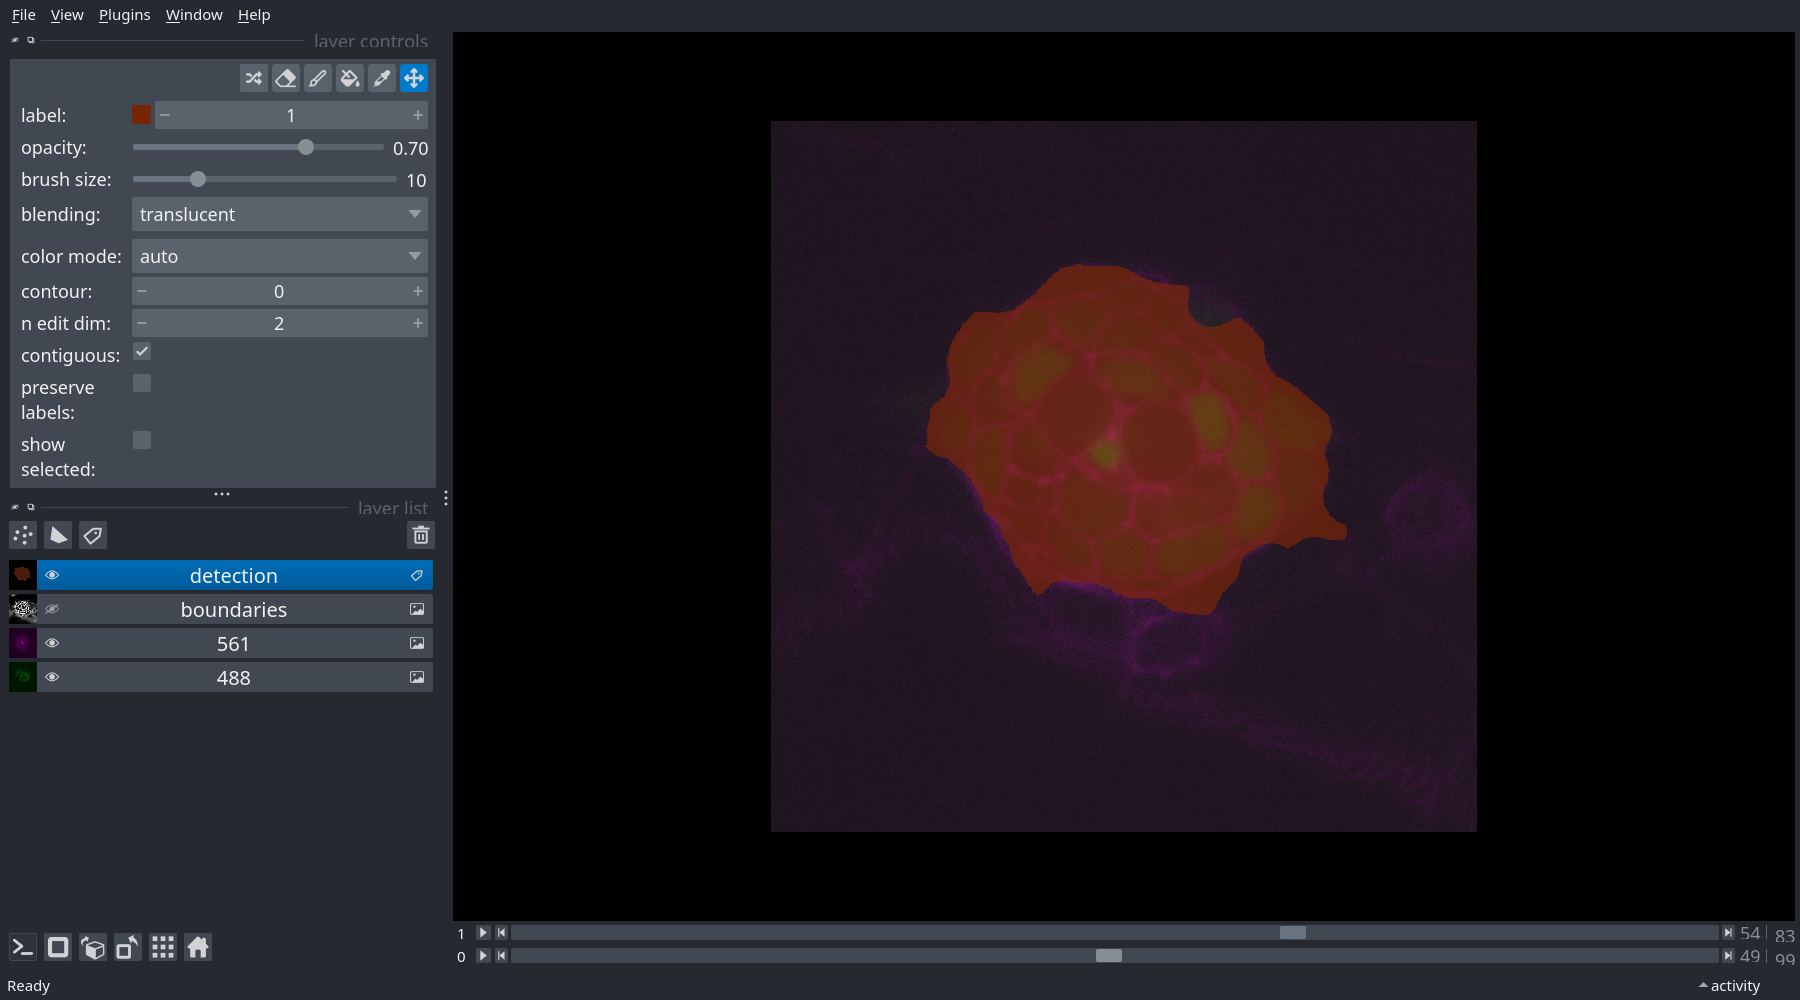

In [5]:
detection = create_zarr(nuclei.shape, bool, store_or_path="detection.zarr", overwrite=True)
array_apply(
    nuclei,
    boundaries,
    out_array=detection,
    func=on_gpu(detect_neuromast),
    sigma=5.0 * scale[-3:],
)

viewer.add_labels(detection, visible=True, scale=scale)

nbscreenshot(viewer)

Now that we have the required detection and boundary map inputs we start the tracking stage.

Ultrack's processing parameters are configured using the `MainConfig` class.
The `track` function wraps the three main `segment`, `link`, and `solve` functions. Each step contains its own parameters in a subconfiguration (e.g., `config.linking_config`).

In this example, the parameters were optimized through inspection.

The configuration documentation can be found [here](https://github.com/royerlab/ultrack/blob/main/ultrack/config/README.md).

In [6]:
cfg = MainConfig()

cfg.data_config.n_workers = 8

cfg.segmentation_config.n_workers = 6
cfg.segmentation_config.min_area = 20_000
cfg.segmentation_config.max_area = 200_000
cfg.segmentation_config.min_frontier = 0.35

cfg.linking_config.n_workers = 16
cfg.linking_config.max_neighbors = 5
cfg.linking_config.max_distance = 3.0  # microns
cfg.linking_config.distance_weight = 0.01

cfg.tracking_config.appear_weight = -1.0
cfg.tracking_config.disappear_weight = -1.0
cfg.tracking_config.division_weight -0.1

pprint(cfg)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=8),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=20000,
│   │   max_area=200000,
│   │   min_frontier=0.35,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7fe12e962830>,
│   │   n_workers=6
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=16,
│   │   max_neighbors=5,
│   │   max_distance=3.0,
│   │   distance_weight=0.01,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-1.0,
│   │   disappear_weight=-1.0,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

We track the cells using the boundary and detection maps, the `scale` parameter let the linking distance operate on the physical space.

In [7]:
track(
    cfg,
    detection=detection,
    edges=boundaries,
    overwrite=True,
    scale=scale,
)

Linking nodes.: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:09<00:00, 10.50it/s]


Academic license - for non-commercial use only - expires 2024-08-06
Using GRB solver
Solving ILP batch 0
Constructing ILP ...
Solving ILP ...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 29307 rows, 44453 columns and 95545 nonzeros
Model fingerprint: 0x57c7714f
Variable types: 0 continuous, 44453 integer (44453 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-18, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 5464 rows and 9462 columns
Presolve time: 0.14s
Presolved: 23843 rows, 34991 columns, 78605 nonzeros
Found heuristic solution: objective 8.7815792
Variable types: 0 continuous, 34991 integer (34991 binary)

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.01

Finally, export the tracking results and visualize them using the napari tracks layer.

Exporting segmentation masks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.68it/s]


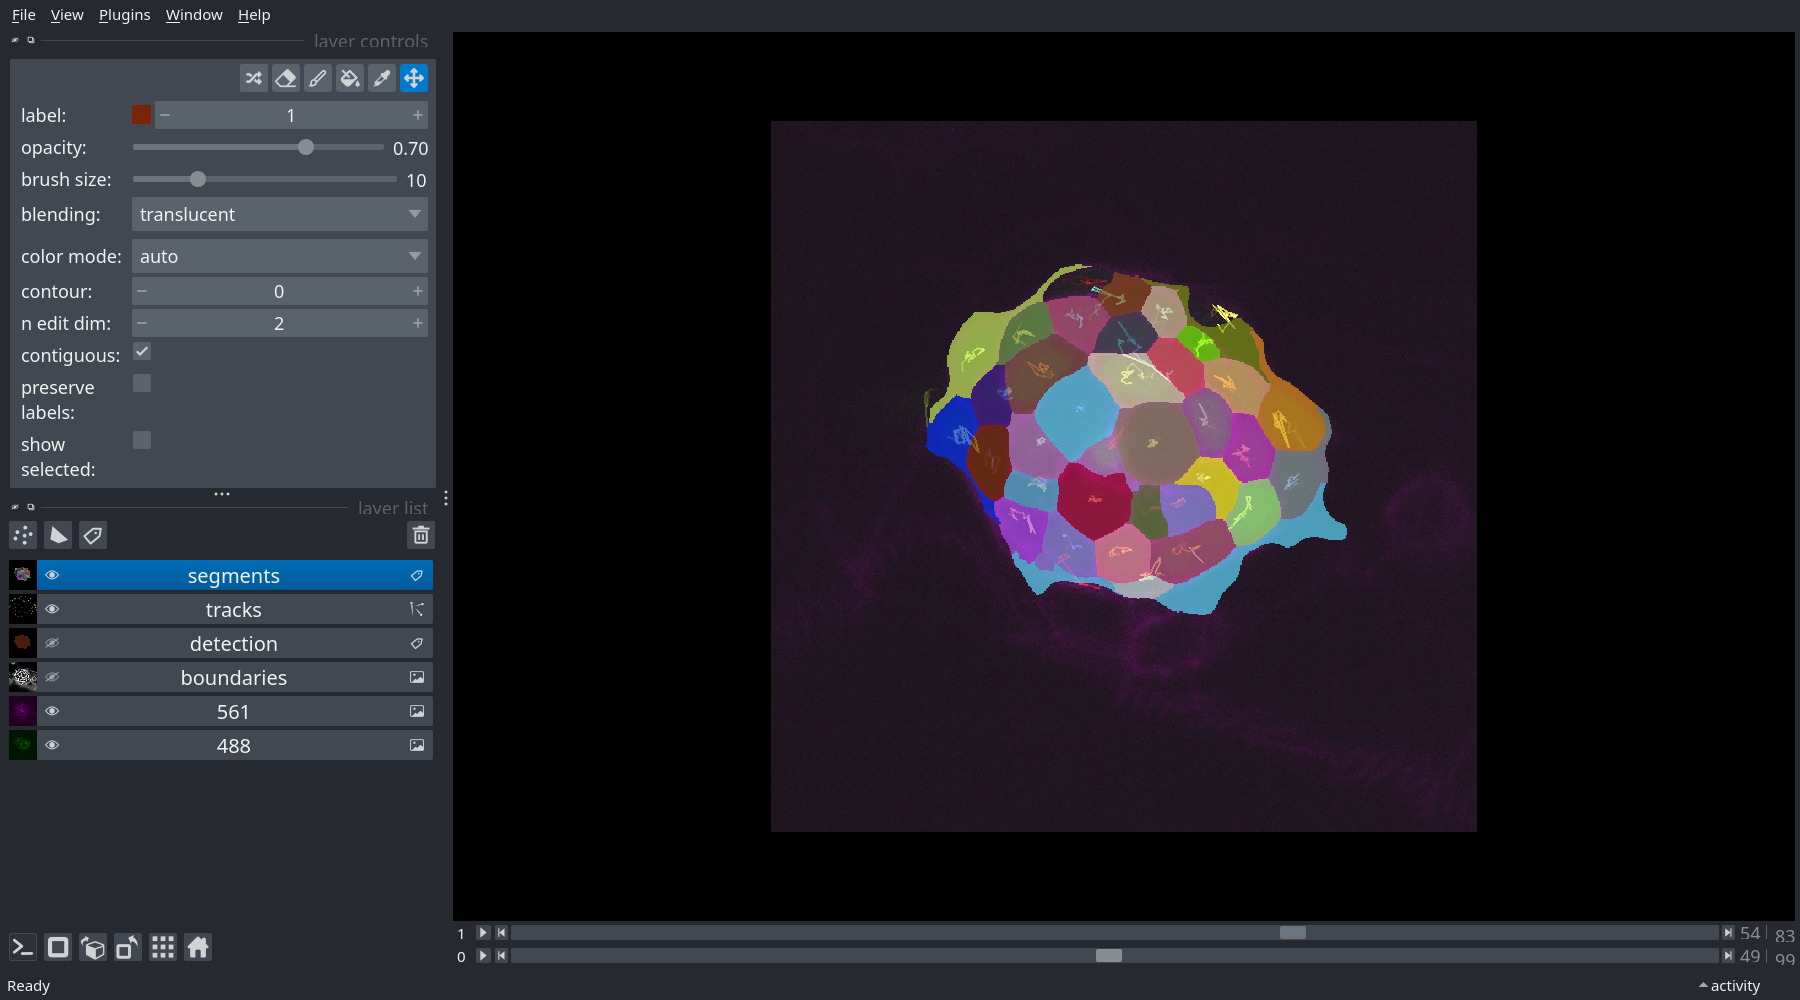

In [8]:
tracks_df, graph = to_tracks_layer(cfg)
tracks_df.to_csv("tracks.csv", index=False)

segments = tracks_to_zarr(
    cfg,
    tracks_df,
    store_or_path="segments.zarr",
    overwrite=True,
)

viewer.layers["detection"].visible = False
viewer.add_tracks(
    tracks_df[["track_id", "t", "z", "y", "x"]],
    name="tracks",
    graph=graph,
    visible=True,
    scale=scale,
)

viewer.add_labels(da.from_zarr(segments), name="segments", scale=scale)

nbscreenshot(viewer)